In [3]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
from utils import fibonacci

![miles-km](./assets/convertion.png)

In [25]:
ONE_KM_TO_MILES=0.621371

## Conversion

$ 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, ... $

Using the fibonacci sequence, we can get some conversions:

## miles to km

To do that, we need to get next value of the fibonacci sequence:
$F(N+1) = miles \to km$

$miles = 8$\
$km = 13$

```
1km  - 0.621371 miles
xkm  - 8 miles
```
$8 = x * 0.621371$\
$x = {8 \over 0.621371}$\
$x = 12.874755983140506 \approx 13km$

---

## km to miles

To do that, we need to get actual value of the fibonacci sequence:
$F(N) = km \to miles$


$km = 13$\
$miles = 8$

```
1km  - 0.621371 miles
13km  - x miles
```

$x = 13*0.621371$\
$x = 8.077823 \approx 8 miles$

In [40]:
@functools.lru_cache(maxsize=1000)
def km_to_miles(km, last=0, n=0):
    fib_value = fibonacci(n)

    if(fib_value == km):
        return last

    if(fib_value > km*ONE_KM_TO_MILES):
        raise Exception(f"{km} Not in the sequence")

    return km_to_miles(km, fib_value, n+1)

In [44]:
km_to_miles(21)

13

In [37]:
@functools.lru_cache(maxsize=1000)
def miles_to_km(miles, last=0, n=0):
    fib_value = fibonacci(n)

    if(last == miles):
        return fib_value

    if(fib_value > miles/ONE_KM_TO_MILES):
        raise Exception(f"{miles} Not in the sequence")

    return miles_to_km(miles, fib_value, n+1)

In [48]:
miles_to_km(13)

21

For values that aren't in the fibonacci sequence, we can break the value into fibonacci values:


$ 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, ... $

$(km \to miles)(12)$\
$12 \to {8 + 3 + 1}$

So

$12km \to miles = 5+2+1 = 8$

In [57]:
km_miles = lambda km : km*ONE_KM_TO_MILES
miles_km = lambda miles: miles/ONE_KM_TO_MILES

In [54]:
km_miles(12)

7.4564520000000005

$7.4564520000000005 \approx 8$

$(km \to miles)(24)$\
$24 \to {21 + 3}$

$13 + 2 = 15$

In [58]:
km_miles(24)

14.912904000000001

$14.912904000000001 \approx 15$

---

In [4]:
PI = np.pi

In [5]:
class Oracle(QuantumCircuit):
    def __init__(self, n_qubits):
        assert n_qubits >= 2, "Invalid number of qubits!"
        self.n_qubits = n_qubits
        super().__init__(n_qubits, name="oracle")
        self.generate()
        
    def generate(self):
        self.ry(PI/2, range(self.n_qubits))
        for i in range(self.n_qubits-1):
            self.cry(-PI/2, i, i+1)

    def simulate(self, backend=AerSimulator(), shots=1000):
        qc_copy = self.copy()
        qc_copy.measure_all()
        transpiled_qc = transpile(qc_copy, backend)
        return backend.run(transpiled_qc).result().get_counts()

    def get_unitary(self, backend=AerSimulator()):
        qc_copy = self.copy()
        qc_copy.save_unitary()
        transpiled_qc = transpile(qc_copy, backend)
        return backend.run(transpiled_qc).result().get_unitary()

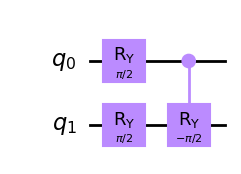

<IPython.core.display.Latex object>

In [7]:
oracle = Oracle(2)
display(oracle.draw('mpl'))
array_to_latex(oracle.get_unitary())

In [79]:
class KM_to_Miles:
    def __init__(self, iterations=3, base_oracle=Oracle):
        self.iterations = iterations
        self.total_qubits = 2
        self.oracle = base_oracle
        self.qc = self.oracle(2)
        self.results = pd.DataFrame(columns=['n', 'result'])

    def run(self, backend=AerSimulator(), shots=1000, debug=True):
        for i in tqdm(range(self.iterations)):
            results = self.qc.simulate(backend, shots)
            fibonacci_number = len(results)

            if(debug):
                print('-'*20)
                print(f'i: {i}')
                print(f'n: {self.total_qubits}')
                print(f'F({i}): {fibonacci_number}') 
            
            self.results = pd.concat([self.results, pd.DataFrame({'n':self.total_qubits, 'result':fibonacci_number}, columns=['n', 'result'], index=[iter])], ignore_index=True)
            
            self.total_qubits+=1
            self.qc = self.oracle(self.total_qubits)

In [83]:
converter = KM_to_Miles(10)
converter.run(debug=True)

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------
i: 0
n: 2
F(0): 3
--------------------
i: 1
n: 3
F(1): 5
--------------------
i: 2
n: 4
F(2): 8
--------------------
i: 3
n: 5
F(3): 13
--------------------
i: 4
n: 6
F(4): 21
--------------------
i: 5
n: 7
F(5): 34
--------------------
i: 6
n: 8
F(6): 55
--------------------
i: 7
n: 9
F(7): 89
--------------------
i: 8
n: 10
F(8): 142
--------------------
i: 9
n: 11
F(9): 216


In [84]:
converter.results

,n,result
0,2,3
1,3,5
2,4,8
3,5,13
4,6,21
5,7,34
6,8,55
7,9,89
8,10,142
9,11,216


In [134]:
generate_km_to_miles_table(20)

,km,miles
0,1,0.621371
1,2,1.242742
2,3,1.864113
3,4,2.485484
4,5,3.106855
5,6,3.728226
6,7,4.349597
7,8,4.970968
8,9,5.592339
9,10,6.213710
